# Diabetes Health Indicators - Data Analyse

**Dataset:** CDC BRFSS 2015 (Behavioral Risk Factor Surveillance System)

Dit notebook:
1. Kloont de repository en installeert dependencies
2. Downloadt de dataset van Kaggle
3. Bekijkt de onderzoeksvragen
4. Laadt, schoont en splitst de data per onderzoeksvraag
5. Beschrijft de data met statistieken
6. Visualiseert de data met grafieken en correlatiematrices
7. Voert logistische regressieanalyses uit (enkelvoudig en meervoudig)
8. Voert een clusteranalyse uit om lifestyle profielen te identificeren

## Stap 1: Repository klonen en dependencies installeren

In [ ]:
%git clone https://github.com/Pablo-Atanes/Minor-bigdata.git
%cd Minor-bigdata
%pip install -q -r requirements.txt

## Stap 2: Dataset downloaden van Kaggle

De `data/` map staat in `.gitignore` en zit dus niet in de repository.
We downloaden de dataset via `kagglehub`.

**Let op:** Bij de eerste keer wordt gevraagd om je Kaggle credentials.
Deze kun je aanmaken op https://www.kaggle.com/settings > API > Create New Token.

In [1]:
%pip install -q kagglehub

import kagglehub
import shutil
import os

# Dataset downloaden van Kaggle
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
print(f"Dataset gedownload naar: {path}")

# CSV bestanden kopieren naar data/ map
os.makedirs("data", exist_ok=True)
for f in os.listdir(path):
    if f.endswith(".csv"):
        shutil.copy(os.path.join(path, f), os.path.join("data", f))
        print(f"Gekopieerd: {f}")

print("\nBestanden in data/:")
!ls data/


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


c:\Users\PA4GA\Documents\Minor-bigdata\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 6.03M/6.03M [00:00<00:00, 8.55MB/s]

Extracting files...


Dataset gedownload naar: C:\Users\PA4GA\.cache\kagglehub\datasets\alexteboul\diabetes-health-indicators-dataset\versions\1
Gekopieerd: diabetes_012_health_indicators_BRFSS2015.csv
Gekopieerd: diabetes_binary_5050split_health_indicators_BRFSS2015.csv
Gekopieerd: diabetes_binary_health_indicators_BRFSS2015.csv

Bestanden in data/:


'ls' is not recognized as an internal or external command,
operable program or batch file.


## Stap 3: Onderzoeksvragen bekijken

We tonen de inhoud van `research_questions.md` om te bevestigen welke variabelen we nodig hebben.

In [ ]:
!cat research_questions.md

## Stap 4: Data laden, opschonen en opsplitsen

We gebruiken `data_cleaner.py` om de data te laden en **per onderzoeksvraag** op te schonen.
Elke vraag wordt onafhankelijk gecleand: alleen de kolommen die relevant zijn voor die vraag worden gevalideerd.
Rijen worden dus nooit verwijderd vanwege ongeldige waarden in kolommen die de vraag niet gebruikt.

Per kolom worden de volgende stappen uitgevoerd:
1. Alleen de relevante kolommen selecteren
2. Dubbele rijen verwijderen (binnen de subset)
3. Rijen met ontbrekende waarden verwijderen (binnen de subset)
4. Datatypen converteren en waardebereiken valideren (binaire kolommen 0/1, ordinale kolommen binnen bereik)

| Vraag | Onderwerp | Kolommen |
|-------|-----------|----------|
| Q1 | Fruit Consumptie & Diabetes | `Diabetes_binary`, `Fruits` |
| Q2 | Lifestyle Patronen (Apriori) | `Diabetes_binary`, `Smoker`, `PhysActivity`, `Fruits`, `Veggies`, `HvyAlcoholConsump` |
| Q3 | Socio-economische Status | `Diabetes_binary`, `Income`, `Education` |
| Q4 | Cumulatief Lifestyle Effect | `Diabetes_binary`, `Smoker`, `PhysActivity`, `Fruits`, `HvyAlcoholConsump`, `Unhealthy_Lifestyle_Score` |
| Q5 | Cholesterol + Bloeddruk | `Diabetes_binary`, `HighBP`, `HighChol`, `HighBP_x_HighChol` |

In [2]:
from data_procesing.data_cleaner import load_and_clean_all, save_questions_to_json

# Data laden en per vraag opschonen
questions = load_and_clean_all()

# Opslaan als JSON
save_questions_to_json(questions)

Geladen: 253680 rijen, 22 kolommen
Na deduplicatie: 229474 rijen (24206 duplicaten verwijderd)

q1_fruit_diabetes:
  229474 -> 229474 rijen (0 verwijderd)
q2_lifestyle_patterns:
  229474 -> 229474 rijen (0 verwijderd)
q3_socioeconomic:
  229474 -> 229474 rijen (0 verwijderd)
q4_cumulative_lifestyle:
  229474 -> 229474 rijen (0 verwijderd)
q5_cholesterol_bloodpressure:
  229474 -> 229474 rijen (0 verwijderd)

Saved q1_fruit_diabetes.json (229474 rijen, 2 kolommen)
Saved q2_lifestyle_patterns.json (229474 rijen, 6 kolommen)
Saved q3_socioeconomic.json (229474 rijen, 3 kolommen)
Saved q4_cumulative_lifestyle.json (229474 rijen, 6 kolommen)
Saved q5_cholesterol_bloodpressure.json (229474 rijen, 4 kolommen)


## Stap 4: Data laden, opschonen en opsplitsen

We gebruiken `data_cleaner.py` om de data te laden en **per onderzoeksvraag** op te schonen.

**Opmerking over datatypes (belangrijk):** in deze stap worden expliciet geschikte datatypes toegewezen om geheugengebruik te verlagen en bewerkingen te versnellen. Kort:

- `Diabetes_binary`: **blijft numeriek** (`uint8`) — noodzakelijk voor mean()/regressies
- Binaire en kleine ordinale kolommen: `uint8` (sneller, minder geheugen)
- `BMI`: `float32` (voldoende nauwkeurig, halveert geheugen t.o.v. float64)

Cleaning blijft per‑vraag zodat rijen niet onnodig verwijderd worden vanwege irrelevante kolommen. Gebruik de helper `compare_cleaning_strategies()` om per‑vraag vs global‑clean verschillen en geheugenimpact te controleren.

In [ ]:
from data_procesing.data_description import describe_all

# Beschrijvende statistieken voor alle onderzoeksvragen
all_stats = describe_all(questions)

## Stap 4: Data laden, opschonen en opsplitsen

We gebruiken `data_cleaner.py` om de data te laden en **per onderzoeksvraag** op te schonen.

Stappen in deze fase:
1. Kolommen selecteren die relevant zijn voor elke onderzoeksvraag
2. Dubbele rijen verwijderen
3. Missende waarden verwijderen (binnen de subset)
4. **Datatypen converteren en waardebereiken valideren** — binaire/ordinale kolommen → `uint8`; `BMI` → `float32`; `Diabetes_binary` blijft numeriek (`uint8`) voor analyses
5. Eventuele afgeleide kolommen toevoegen (bijv. `Unhealthy_Lifestyle_Score`, interactietermen)

Deze aanpak (partition → clean) voorkomt dat ongerelateerde kolommen rijen verwijderen voor andere vragen.

In [4]:
from data_procesing.data_presenting import plot_q1, plot_q2, plot_q3, plot_q4, plot_q5

### Q1: Fruit Consumptie & Diabetes
> "Heeft het regelmatig eten van fruit (>=1x per dag) invloed op de kans op diabetes?"

**Grafiekkeuze:**
- **Proportioneel staafdiagram** — vergelijkt de diabetes verhouding tussen fruiteters en niet-fruiteters.
  Dit is beter dan een gewoon staafdiagram omdat we niet het *aantal* willen vergelijken, maar het *percentage* diabetes binnen elke groep.
- **Cirkeldiagram** — toont hoeveel mensen wel/niet dagelijks fruit eten (verdeling van de onafhankelijke variabele).

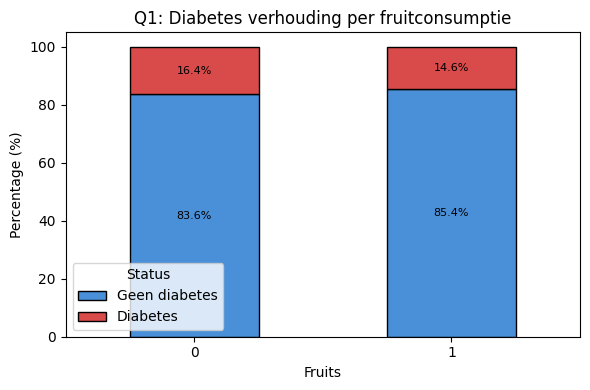

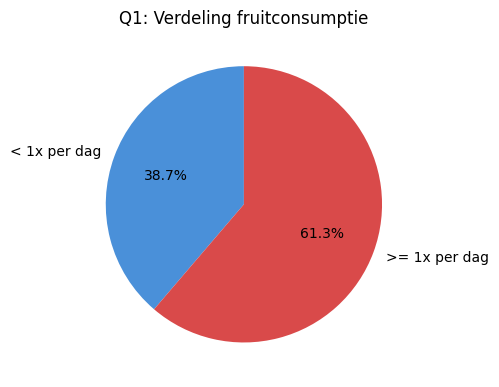

In [5]:
plot_q1(questions["q1_fruit_diabetes"])

**Interpretatie Q1:**
- Het proportioneel staafdiagram toont of er een verschil is in diabetes percentage tussen mensen die wel (>=1x/dag) en niet (<1x/dag) dagelijks fruit eten.
- Als het rode deel (diabetes) duidelijk kleiner is bij Fruits=1, dan suggereert dit een beschermend effect van fruitconsumptie.
- Het cirkeldiagram toont dat het merendeel van de respondenten aangeeft dagelijks fruit te eten, wat belangrijk is voor de betrouwbaarheid van de vergelijking.

### Q2: Lifestyle Patronen & Diabetes
> "Welke lifestyle patronen komen vaak samen voor bij mensen met diabetes?"

**Grafiekkeuze:**
- **Horizontaal staafdiagram** — vergelijkt het diabetes percentage over alle 5 lifestyle factoren in een grafiek.
  Dit is beter dan 5 losse staafdiagrammen omdat je de factoren direct kunt vergelijken.
  De stippellijn toont het gemiddelde diabetes percentage; factoren boven de lijn (rood) zijn risicofactoren.
- **Correlatiematrix (heatmap)** — toont de onderlinge samenhang tussen alle factoren, inclusief diabetes.

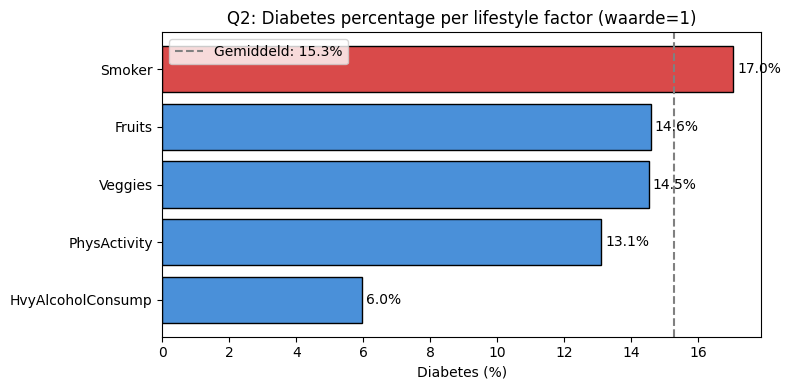

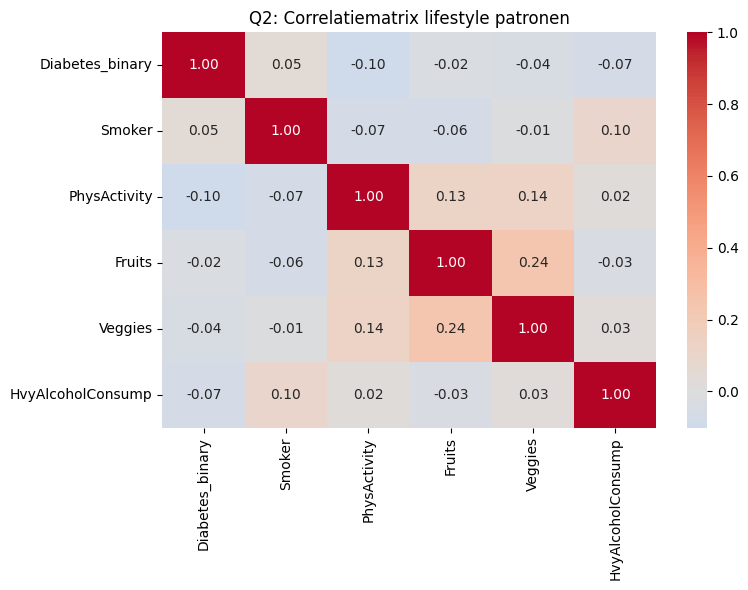

In [6]:
plot_q2(questions["q2_lifestyle_patterns"])

**Interpretatie Q2:**
- Het horizontale staafdiagram laat zien welke lifestyle factoren het sterkst geassocieerd zijn met diabetes.
  Factoren die boven de gemiddelde stippellijn liggen (rood) komen vaker voor bij diabetespatienten.
- In de correlatiematrix duiden waarden dicht bij **+1** op een sterke positieve samenhang, en waarden dicht bij **-1** op een negatieve samenhang.
  Let op: correlatie betekent niet automatisch causaliteit — het toont alleen dat twee variabelen samen bewegen.

### Q3: Socio-economische Status & Diabetes
> "Heeft een lagere socio-economische status een negatief effect op de kans op diabetes?"

**Grafiekkeuze:**
- **Lijndiagrammen** — tonen de trend van diabetes percentage over inkomen (1-8) en opleiding (1-6).
  Dit is beter dan staafdiagrammen voor ordinale data, omdat de **volgorde** en de **trend** belangrijk zijn.
  Een dalende lijn betekent: hoe hoger het inkomen/de opleiding, hoe lager het diabetes percentage.
- **Scatter plot (x/y-diagram)** — toont de relatie tussen inkomen en opleiding, gekleurd op diabetes status.
- **Correlatiematrix** — kwantificeert de samenhang.

In [ ]:
plot_q3(questions["q3_socioeconomic"])

**Interpretatie Q3:**
- De lijndiagrammen tonen of er een dalende trend is: hoe hoger het inkomen/de opleiding, hoe lager het diabetes percentage.
  Een steil dalende lijn wijst op een sterk beschermend effect van socio-economische status.
- De scatter plot toont of diabetespatienten (rode punten) zich concentreren in het gebied met lagere inkomens en lagere opleiding.
- De negatieve correlatie in de matrix bevestigt: hogere socio-economische status hangt samen met minder diabetes.

### Q4: Cumulatief Effect Lifestyle Factors
> "Hoe verandert het diabetes risico bij meerdere ongezonde lifestyle factors?"

**Grafiekkeuze:**
- **Vlakdiagram** — toont hoe het diabetes risico stijgt naarmate de Unhealthy Lifestyle Score toeneemt.
  Dit is beter dan een staafdiagram omdat het de **cumulatieve opbouw** benadrukt met het gevulde oppervlak.
  Als de curve steiler wordt bij hogere scores, dan is het effect synergistisch (niet-lineair).
- **Cirkeldiagram** — toont de verdeling van de score in de populatie (hoeveel mensen hebben score 0, 1, 2, etc.).
- **Bubbeldiagram** — combineert drie dimensies: de score (x-as), het diabetes percentage (y-as) en het aantal personen (grootte van de bubbel).

In [ ]:
plot_q4(questions["q4_cumulative_lifestyle"])

**Interpretatie Q4:**
- Het vlakdiagram toont of het diabetes risico **lineair** (gelijkmatig) of **exponentieel** (steeds sneller) stijgt met het aantal risicofactoren.
  Een steeds steiler wordende curve duidt op een synergistisch effect: de combinatie van factoren is erger dan de som.
- Het cirkeldiagram toont dat de meeste mensen een score van 1-2 hebben — extreme scores (0 of 4) zijn zeldzamer.
- In het bubbeldiagram toont de grootte van elke bubbel hoeveel personen in die groep zitten.
  Grotere bubbels betekenen betrouwbaardere schattingen van het diabetes percentage.

### Q5: Cholesterol + Bloeddruk & Diabetes
> "Verhoogt de combinatie van hoog cholesterol en hoge bloeddruk het diabetes risico synergistisch?"

**Grafiekkeuze:**
- **2x2 Heatmap** — toont het diabetes percentage per combinatie van HighBP en HighChol.
  Dit is beter dan staafdiagrammen omdat de **2x2 structuur** het interactie-effect direct zichtbaar maakt.
  Als de rechtsonder-cel (beide condities aanwezig) disproportioneel hoog is, dan is er een synergistisch effect.
- **Proportioneel staafdiagram** — toont de diabetes verhouding per combinatiegroep.
- **Correlatiematrix** — toont de samenhang inclusief de interactieterm.

In [ ]:
plot_q5(questions["q5_cholesterol_bloodpressure"])

**Interpretatie Q5:**
- De 2x2 heatmap maakt het interactie-effect direct zichtbaar:
  - **Linksboven** (geen BP, geen Chol): laagste diabetes percentage (referentiegroep)
  - **Rechtsboven/Linksonder** (een van beide condities): verhoogd percentage
  - **Rechtsonder** (beide condities): als dit getal **meer** is dan de som van de individuele effecten, dan is er sprake van synergie
- Het proportioneel staafdiagram bevestigt dit patroon in een andere weergave.
- De correlatiematrix toont dat HighBP en HighChol zelf ook positief gecorreleerd zijn — ze komen dus vaker samen voor.

---
## Stap 7: Regressieanalyse

We gebruiken **logistische regressie** omdat onze afhankelijke variabele (`Diabetes_binary`) binair is (0 of 1).
Logistische regressie modelleert de kans op diabetes als functie van de predictorvariabelen.

### Waarom logistische regressie?
- Lineaire regressie is **niet geschikt** voor een binaire uitkomst (voorspelt waarden buiten 0-1)
- Logistische regressie modelleert de **log-odds** (logaritme van de kansverhouding)
- Het resultaat is een **odds ratio (OR)**: hoe de kansverhouding verandert per eenheid stijging van de predictor

### Hoe lees je de resultaten?
| Begrip | Betekenis |
|--------|-----------|
| **Coefficient** | Verandering in log-odds per eenheid stijging van de predictor |
| **Odds Ratio (OR)** | `exp(coefficient)` — de vermenigvuldigingsfactor voor de kansverhouding |
| **OR > 1** | De predictor **verhoogt** de kans op diabetes |
| **OR < 1** | De predictor **verlaagt** de kans op diabetes |
| **OR = 1** | Geen effect |
| **p-waarde < 0.05** | Het effect is statistisch significant |
| **95% CI** | Betrouwbaarheidsinterval — als dit interval 1 bevat, is het effect niet significant |
| **Pseudo R²** | Hoe goed het model de data verklaart (0 = slecht, 1 = perfect) |

### Overzicht analyses
- **11 enkelvoudige regressies** (1 predictor per model)
- **4 meervoudige regressies** (meerdere predictoren per model)

### Q1: Fruit Consumptie & Diabetes — Regressie
> 1 enkelvoudige logistische regressie: Fruits → Diabetes_binary

We toetsen of dagelijkse fruitconsumptie de kans op diabetes significant beinvloedt.

In [ ]:
from data_procesing.data_regression import (
    regression_q1, regression_q2, regression_q3, regression_q4, regression_q5
)

# Q1: Enkelvoudige regressie — Fruits → Diabetes
q1_models = regression_q1(questions["q1_fruit_diabetes"])

**Interpretatie Q1 regressie:**
- De odds ratio (OR) geeft aan hoeveel keer groter (of kleiner) de kans op diabetes is bij dagelijkse fruitconsumptie vergeleken met geen dagelijkse fruitconsumptie.
- Een OR < 1 betekent dat fruit eten de kans **verlaagt**, een OR > 1 betekent dat het de kans **verhoogt**.
- Let op de p-waarde: alleen als p < 0.05 is het effect statistisch significant.
- De lage Pseudo R² is verwacht: een enkele binaire predictor kan niet veel variatie verklaren in diabetes risico.

### Q2: Lifestyle Patronen & Diabetes — Regressie
> 5 enkelvoudige logistische regressies (per factor) + 1 meervoudige regressie (alle factoren samen)

Eerst toetsen we elke lifestyle factor apart. Daarna combineren we ze in een meervoudig model om te zien welke factoren **onafhankelijk** bijdragen aan diabetes risico (gecorrigeerd voor de andere factoren).

In [ ]:
# Q2: 5 enkelvoudige + 1 meervoudige regressie
q2_models = regression_q2(questions["q2_lifestyle_patterns"])

**Interpretatie Q2 regressie:**
- **Enkelvoudige regressies:** Elke factor wordt apart getoetst. Dit toont het *bruto* effect van elke factor op diabetes, zonder correctie voor de andere factoren.
- **Meervoudige regressie:** Alle 5 factoren worden tegelijk opgenomen. Dit toont het *netto* effect: de bijdrage van elke factor **gecorrigeerd voor** de andere factoren.
- Vergelijk de odds ratios tussen enkelvoudig en meervoudig: als een OR sterk verandert, dan was het enkelvoudige effect deels te verklaren door andere factoren (confounding).
- Factoren met OR > 1 in het meervoudige model zijn onafhankelijke risicofactoren; factoren met OR < 1 zijn onafhankelijke beschermende factoren.

### Q3: Socio-economische Status & Diabetes — Regressie
> 2 enkelvoudige logistische regressies (Income, Education) + 1 meervoudige regressie (Income + Education samen)

We onderzoeken of inkomen en opleidingsniveau elk apart en samen de kans op diabetes voorspellen.

In [ ]:
# Q3: 2 enkelvoudige + 1 meervoudige regressie
q3_models = regression_q3(questions["q3_socioeconomic"])

**Interpretatie Q3 regressie:**
- **Income:** De OR geeft aan hoe de kans op diabetes verandert per stap omhoog in inkomenscategorie (1 = <$10k, 8 = $75k+). Een OR < 1 betekent: hoe hoger het inkomen, hoe lager het diabetes risico.
- **Education:** De OR geeft aan hoe de kans verandert per stap omhoog in opleidingsniveau (1 = geen opleiding, 6 = universitair).
- **Meervoudig model:** Toont het effect van inkomen *na correctie voor opleiding* en vice versa. Als beide significant blijven, zijn het onafhankelijke voorspellers van diabetes.
- Deze ordinale variabelen worden hier lineair gemodelleerd — we nemen aan dat elke stap omhoog in categorie een gelijk effect heeft op de log-odds.

### Q4: Cumulatief Effect Lifestyle Factors — Regressie
> 1 enkelvoudige regressie (Unhealthy_Lifestyle_Score) + 1 meervoudige regressie (individuele factoren)

We vergelijken twee benaderingen:
1. De samengestelde score als enkele predictor — toont het cumulatieve effect
2. De individuele factoren als aparte predictoren — toont welke factoren het meest bijdragen

In [ ]:
# Q4: 1 enkelvoudige + 1 meervoudige regressie
q4_models = regression_q4(questions["q4_cumulative_lifestyle"])

**Interpretatie Q4 regressie:**
- **Score-model:** De OR per punt stijging toont hoeveel het diabetes risico stijgt per extra risicofactor. Als OR = 1.15, dan stijgt de kans met 15% per extra factor.
- **Meervoudig model:** Door de individuele factoren los te modelleren zien we welke het sterkst bijdragen. Niet alle factoren hoeven even zwaar te wegen — het meervoudige model laat dit zien.
- **Vergelijking:** Als het meervoudige model een hogere Pseudo R² heeft dan het score-model, dan gaat er informatie verloren door de factoren tot een enkele score samen te vatten.
- De Unhealthy Lifestyle Score behandelt alle factoren als even zwaar (elk +1 punt). Het meervoudige model laat zien of dit realistisch is.

### Q5: Cholesterol + Bloeddruk & Diabetes — Regressie
> 2 enkelvoudige regressies (HighBP, HighChol) + 1 meervoudige regressie met interactieterm

Het meervoudige model bevat een **interactieterm** (`HighBP × HighChol`) om te toetsen of de combinatie van beide condities het diabetes risico **synergistisch** verhoogt (meer dan de som van de individuele effecten).

In [ ]:
# Q5: 2 enkelvoudige + 1 meervoudige regressie (met interactieterm)
q5_models = regression_q5(questions["q5_cholesterol_bloodpressure"])

**Interpretatie Q5 regressie:**
- **Enkelvoudige regressies:** Tonen het individuele effect van hoge bloeddruk en hoog cholesterol op diabetes risico.
- **Meervoudige regressie met interactie:** Het model bevat drie termen:
  - `HighBP`: het effect van hoge bloeddruk *als HighChol = 0*
  - `HighChol`: het effect van hoog cholesterol *als HighBP = 0*
  - `HighBP_x_HighChol`: het **extra** effect wanneer beide condities aanwezig zijn
- Als de interactieterm significant is met OR > 1, dan is er sprake van **synergie**: de combinatie is erger dan de som van de individuele effecten.
- Als de interactieterm niet significant is, zijn de effecten onafhankelijk (additief op de log-odds schaal).

### Samenvatting Regressieanalyses

| Vraag | Type | Aantal | Belangrijkste bevinding |
|-------|------|--------|------------------------|
| Q1 | Enkelvoudig | 1 | Effect van fruitconsumptie op diabetes |
| Q2 | Enkelvoudig + Meervoudig | 5 + 1 | Welke lifestyle factoren onafhankelijk bijdragen |
| Q3 | Enkelvoudig + Meervoudig | 2 + 1 | Onafhankelijke effecten van inkomen en opleiding |
| Q4 | Enkelvoudig + Meervoudig | 1 + 1 | Cumulatief risico vs. individuele bijdrage |
| Q5 | Enkelvoudig + Meervoudig | 2 + 1 | Synergistisch effect van bloeddruk + cholesterol |
| **Totaal** | | **11 + 4** | **11 enkelvoudige + 4 meervoudige regressies** |

**Methodologische opmerkingen:**
- Alle regressies zijn **logistisch** omdat de uitkomstvariabele binair is (0/1)
- Odds ratios (OR) zijn de maat voor effectgrootte: OR > 1 = risicoverhogend, OR < 1 = beschermend
- Significantie wordt getoetst met de Wald-toets (z-waarde); p < 0.05 is significant
- De Pseudo R² (McFadden) is typisch laag bij logistische regressie — waarden van 0.2-0.4 worden al als uitstekend beschouwd
- Meervoudige regressie corrigeert voor confounding en toont **onafhankelijke** effecten

---
## Stap 8: Clusteranalyse

### Wat is clusteranalyse?
Clusteranalyse groepeert respondenten op basis van **overeenkomsten** in hun kenmerken. In tegenstelling tot regressie (die een uitkomst voorspelt) ontdekt clustering **natuurlijke groepen** in de data zonder vooraf te weten hoeveel groepen er zijn.

### Waarom K-Means?
- **K-Means** is een veelgebruikt clustering-algoritme dat respondenten toewijst aan k groepen
- Het minimaliseert de **afstand** binnen elke groep (respondenten in dezelfde groep lijken zoveel mogelijk op elkaar)
- Geschikt voor onze data: alle 5 lifestyle features zijn binair (0/1), dus ze liggen al op dezelfde schaal

### Welke data?
We clusteren de **Q2 lifestyle data** (5 features):
- `Smoker` (0/1), `PhysActivity` (0/1), `Fruits` (0/1), `Veggies` (0/1), `HvyAlcoholConsump` (0/1)

Dit identificeert **lifestyle profielen** — groepen mensen met vergelijkbare gezondheidsgewoonten. Vervolgens vergelijken we het diabetes percentage per profiel.

### Hoe bepalen we het aantal clusters?
1. **Elbow-methode** — plot de inertia (binnen-cluster variatie) per k. Het "knikpunt" waar de daling afvlakt is het optimale k.
2. **Silhouette score** — meet hoe goed elke respondent bij zijn cluster past (0 = slecht, 1 = perfect). Het k met de hoogste score is het beste.

In [ ]:
from data_procesing.data_clustering import plot_elbow, plot_silhouette_scores

features = ["Smoker", "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump"]
q2 = questions["q2_lifestyle_patterns"]

# Stap 1: Elbow-methode
print("--- Elbow-methode ---")
inertias = plot_elbow(q2, features)

# Stap 2: Silhouette scores
print("\n--- Silhouette scores ---")
scores, best_k = plot_silhouette_scores(q2, features)

**Hoe lees je de grafieken hierboven?**

- **Elbow-methode:** De x-as toont het aantal clusters (k), de y-as de inertia (totale afstand van punten tot hun clustercentrum). Hoe lager de inertia, hoe beter de punten bij hun cluster passen. We zoeken het **knikpunt** — het punt waar extra clusters steeds minder verbetering opleveren.
- **Silhouette score:** Een score van 1.0 = perfecte clustering, 0 = willekeurige toewijzing. De k met de hoogste score is statistisch het beste. Bij binaire data zijn silhouette scores doorgaans lager dan bij continue data — dat is normaal.

We kiezen **k=4** clusters: dit is een goed compromis tussen de elbow-methode (afvlakkingspunt) en de interpreteerbaarheid van de clusters (4 herkenbare lifestyle profielen).

In [ ]:
from data_procesing.data_clustering import run_clustering, plot_cluster_profiles

# K-Means clustering met k=4
q2_clustered, model = run_clustering(q2, features, n_clusters=4)

# Cluster profielen: gemiddelde waarde per feature per cluster
profiles = plot_cluster_profiles(q2_clustered, features)
print("\nCluster profielen (gemiddelde per feature):")
print(profiles.to_string())

**Interpretatie cluster profielen:**

De heatmap toont het gemiddelde van elke lifestyle factor per cluster. Een waarde dicht bij **1.0** (donkerrood) betekent dat bijna iedereen in dat cluster die eigenschap heeft; een waarde dicht bij **0.0** (lichtgeel) betekent dat bijna niemand die eigenschap heeft.

Elk cluster vertegenwoordigt een **lifestyle profiel**:
- Clusters met hoge waarden voor `PhysActivity`, `Fruits`, `Veggies` en lage waarden voor `Smoker`, `HvyAlcoholConsump` zijn **gezonde** profielen
- Clusters met het omgekeerde patroon zijn **ongezonde** profielen
- De exacte benaming van elk cluster hangt af van de gevonden gemiddelden hierboven

In [ ]:
from data_procesing.data_clustering import plot_diabetes_per_cluster

# Diabetes percentage per cluster
rates = plot_diabetes_per_cluster(q2_clustered)

print("\nDiabetes percentage per cluster:")
for cluster, rate in rates.items():
    size = (q2_clustered["Cluster"] == cluster).sum()
    print(f"  Cluster {cluster}: {rate:.1f}% diabetes (n={size:,})")

**Interpretatie diabetes per cluster:**

Het staafdiagram toont het diabetes percentage per cluster. De stippellijn is het **gemiddelde** diabetes percentage over alle respondenten. Clusters boven de lijn (rood) hebben een **hoger dan gemiddeld** diabetes risico; clusters onder de lijn (blauw) een **lager dan gemiddeld** risico.

**Conclusie clusteranalyse:**
- De K-Means clusteranalyse identificeert duidelijke **lifestyle profielen** in de data
- Er is een zichtbaar verband tussen het type lifestyle profiel en het diabetes risico
- Clusters met meer ongezonde gewoonten (roken, geen fysieke activiteit, weinig fruit/groenten) hebben een hoger diabetes percentage
- Dit bevestigt de bevindingen uit de regressieanalyse (Stap 7, Q2): lifestyle factoren zijn geassocieerd met diabetes, en het **patroon** van gedrag — niet alleen individuele factoren — speelt een rol
- De clusteranalyse voegt waarde toe doordat het **combinaties van gedrag** identificeert die samen voorkomen, in plaats van factoren afzonderlijk te bekijken